In [1]:
from transformers import get_cosine_schedule_with_warmup
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import AdamW
from torch.utils.data import DataLoader, Dataset 
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random
from sklearn.metrics import confusion_matrix, f1_score, f1_score, roc_curve, auc, precision_recall_curve, average_precision_score
import seaborn as sns
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
import numpy as np
import torch
from torch.nn.utils.rnn import pad_sequence
import torch.nn as nn

class GloveTokenizer:
    def __init__(self, glove_file_path, pad_token="<PAD>", unk_token="<UNK>"):
        # Load GloVe embeddings from file
        self.embeddings_index = self._load_glove_embeddings(glove_file_path)
        self.pad_token = pad_token
        self.pad_token_id = 0
        self.unk_token = unk_token
        self.unk_token_id = 1

        # Create word-to-index and index-to-word dictionaries
        self.word_index = {word: idx for idx, word in enumerate(self.embeddings_index.keys(), start=2)}
        self.word_index[self.pad_token] = self.pad_token_id
        self.word_index[self.unk_token] = self.unk_token_id
        self.index_word = {idx: word for word, idx in self.word_index.items()}

    def _load_glove_embeddings(self, glove_file_path):
        # Load the GloVe embeddings from file into a dictionary
        embeddings_index = {}
        with open(glove_file_path, 'r', encoding="utf-8") as f:
            for line in f:
                values = line.split()
                word = values[0]
                vector = np.asarray(values[1:], dtype='float32')
                embeddings_index[word] = vector
        return embeddings_index

    def _tokenize_with_subwords(self, word):
        # If word exists in vocabulary, return its index
        if word in self.word_index:
            return [self.word_index[word]]

        # Otherwise, tokenize word into subwords and try to match each subword
        subword_tokens = []
        subwords = normalize_words(word)
        for subword in subwords:
            if subword in self.word_index:
                subword_tokens.append(self.word_index[subword])

        # Return indices of matched subwords, or UNK token if no subwords matched
        if subword_tokens:
            return subword_tokens
        else:
            return [self.unk_token_id]

    def encode(self, texts, max_length=None, return_tensors="list"):
        # Convert single string to list for consistent handling
        if isinstance(texts, str):
            texts = [texts]

        # Tokenize and encode each text in batch
        all_input_ids = []
        for text in texts:
            input_ids = []
            for word in text.split():
                input_ids.extend(self._tokenize_with_subwords(word))
            all_input_ids.append(input_ids)

        # Pad sequences and create attention masks
        input_ids_padded = pad_sequence(
            [torch.tensor(seq, dtype=torch.long) for seq in all_input_ids],
            batch_first=True,
            padding_value=self.pad_token_id
        )

        attention_mask = (input_ids_padded != self.pad_token_id).long()

        # Trim/pad to max_length if specified
        if max_length:
            input_ids_padded = input_ids_padded[:, :max_length]
            attention_mask = attention_mask[:, :max_length]

            if input_ids_padded.shape[1] < max_length:
                pad_size = max_length - input_ids_padded.shape[1]
                padding = torch.full((input_ids_padded.shape[0], pad_size), self.pad_token_id, dtype=torch.long)
                input_ids_padded = torch.cat([input_ids_padded, padding], dim=1)
                
                mask_padding = torch.zeros((attention_mask.shape[0], pad_size), dtype=torch.long)
                attention_mask = torch.cat([attention_mask, mask_padding], dim=1)

        # Return in specified format
        if return_tensors == "pt":
            return {"input_ids": input_ids_padded, "attention_mask": attention_mask}
        else:
            return {"input_ids": input_ids_padded.tolist(), "attention_mask": attention_mask.tolist()}

    def decode(self, token_ids_batch, skip_special_tokens=False):
        # Convert tensor to list for consistent handling
        if isinstance(token_ids_batch, torch.Tensor):
            if token_ids_batch.dim() != 2:
                raise ValueError("Input tensor must be 2-dimensional.")
            token_ids_batch = token_ids_batch.tolist()

        # Ensure batch format
        if isinstance(token_ids_batch[0], int):
            token_ids_batch = [token_ids_batch]

        # Decode each sequence in batch
        all_texts = []
        for token_ids in token_ids_batch:
            words = []
            for idx in token_ids:
                word = self.index_word.get(idx, self.unk_token)
                if skip_special_tokens and word == self.pad_token:
                    continue
                words.append(word)
            all_texts.append(" ".join(words))

        # Return single or list of decoded texts
        return all_texts if len(all_texts) > 1 else all_texts[0]

class GloveTokenizerNoSub(GloveTokenizer):
    def __init__(self, glove_file_path, pad_token="<PAD>", unk_token="<UNK>"):
        super().__init__(glove_file_path, pad_token, unk_token)

    def _tokenize_with_subwords(self, word):
        if word in self.word_index:
            return [self.word_index[word]]
        else:
            return [self.unk_token_id]

class GloveEmbedding(nn.Module):
    def __init__(self, glove_file_path, embedding_dim=100, trainable=False, pad_token="<PAD>", unk_token="<UNK>"):
        super(GloveEmbedding, self).__init__()
        # Initialize vocabulary and embedding matrix with GloVe embeddings
        self.word_index, embedding_matrix = self._load_glove_embeddings(glove_file_path, embedding_dim, pad_token, unk_token)
        
        # Set up embedding layer with GloVe weights
        vocab_size = embedding_matrix.shape[0]
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.embedding.weight.data.copy_(torch.from_numpy(embedding_matrix))
        self.embedding.weight.requires_grad = trainable

    def _load_glove_embeddings(self, glove_file_path, embedding_dim, pad_token, unk_token):
        # Load GloVe embeddings and build vocabulary and embedding matrix
        embeddings_index = {}
        with open(glove_file_path, 'r', encoding="utf-8") as f:
            for line in f:
                values = line.split()
                word = values[0]
                vector = np.asarray(values[1:], dtype='float32')
                embeddings_index[word] = vector
        
        # Create word index, and initialize embedding matrix
        word_index = {word: idx for idx, word in enumerate(embeddings_index.keys(), start=2)}
        word_index[pad_token] = 0
        word_index[unk_token] = 1

        vocab_size = len(word_index)
        embedding_matrix = np.zeros((vocab_size, embedding_dim))
        for word, idx in word_index.items():
            embedding_vector = embeddings_index.get(word)
            if embedding_vector is not None:
                embedding_matrix[idx] = embedding_vector
            elif word == unk_token:
                embedding_matrix[idx] = np.random.normal(size=(embedding_dim,))
            elif word == pad_token:
                embedding_matrix[idx] = np.zeros(embedding_dim)
        
        return word_index, embedding_matrix

    def forward(self, x):
        # Perform embedding lookup
        return self.embedding(x)

def test(tokenizer):
    embedding_layer = GloveEmbedding(glove_file_path, embedding_dim=100)

    # Example batch of texts
    texts = ["hello world this is <UNK> test",
            "another example sentence for testing",
            "batch processing with <PAD> and <UNK> tokens",
            "Check the price of the new gadget ($199) at 'Tech-Store', " \
        "and don't forget to use the discount code 'SAVE20' for 20% off on your next purchase! " \
        "For more info, call #123 or visit www.tech-store.com & sign up."]

    # Encode batch with tokenizer, returning list format
    encoded_list = tokenizer.encode(texts, max_length=60, return_tensors="list")
    print("Encoded Batch (List):", encoded_list)

    # Encode batch with tokenizer, returning torch tensor format
    encoded_tensor = tokenizer.encode(texts, max_length=60, return_tensors="pt")
    print("Encoded Batch (Torch):", encoded_tensor)
    print("Shape:", encoded_tensor["input_ids"].shape, encoded_tensor["attention_mask"].shape)

    # Decode batch with tokenizer
    decoded_texts = tokenizer.decode(encoded_tensor["input_ids"])
    print("Decoded Batch (Tensor):", decoded_texts)
    
    # Decode list format
    decoded_texts = tokenizer.decode(encoded_list["input_ids"])
    print("Decoded Batch (List):", decoded_texts)
    
    # Pass encoded input_ids through embedding layer
    embedded_output = embedding_layer(encoded_tensor["input_ids"])
    print("Embedded Output Shape (Batch):", embedded_output.shape)
    print("Embedded Output Shape (Batch):", embedded_output)
    
    # Verify alignment of embeddings
    test_word = "text"  # Word to check
    if test_word in tokenizer.word_index:
        test_index = tokenizer.word_index[test_word]
        
        # Retrieve GloVe vector
        glove_vector = torch.tensor(tokenizer.embeddings_index[test_word], dtype=torch.float32)
        
        # Retrieve nn.Embedding vector
        embedding_vector = embedding_layer.embedding.weight[test_index]
        
        # Print and compare vectors
        print(f"GloVe vector for '{test_word}':", glove_vector)
        print(f"Embedding vector for '{test_word}':", embedding_vector)
        
        # Check if vectors align
        if torch.allclose(glove_vector, embedding_vector, atol=1e-6):
            print(f"The embedding for '{test_word}' is correctly aligned with the original GloVe vector.")
        else:
            print(f"The embedding for '{test_word}' is NOT aligned with the original GloVe vector.")
    else:
        print(f"The word '{test_word}' is not in the tokenizer's vocabulary.")

In [3]:
import re
import unidecode

def load_contractions(file_path):
    contractions = {}
    with open(file_path, "r") as file:
        for line in file:
            line = line.strip()
            if line:
                contraction, expansion = line.split(":")
                contraction = contraction.strip()
                expansion = [word.strip() for word in expansion.split(",")]
                contractions[contraction] = expansion
    return contractions

def normalize_words(text): # stupid but works
    words = []
    contractions = load_contractions("contractions.txt")
    text = unidecode.unidecode(text) # e.g. "café" -> "cafe"
    text = text.lower()
    for contraction, expansion in contractions.items():
        text = re.sub(rf"\b{contraction}\b", " ".join(expansion), text) # e.g. "I'm" -> "I am"
    text = re.sub(r"[`\[\]\"]", "", text) # e.g. "`rock[n]roll`" -> "rocknroll"
    text = re.sub(r"'s(?=[^a-zA-Z]|$)", r" 's ", text) # e.g. "John's" -> "John 's"
    text = re.sub(r"s'(?=[^a-zA-Z]|$)", r"s 's ", text) # e.g. "dogs'" -> "dogs 's"
    text = re.sub(r"[/-]", " ", text) # e.g. "rock-n-roll" -> "rock n roll"
    text = re.sub(r"([@#&%+:,.?!$€£¥\(\)])", r" \1 ", text) # e.g. "rock&roll" -> "rock & roll"
    text = re.sub(r"(?<!s)'(?!s\b\s|s$)", "", text) # e.g. "rock'n'roll" -> "rocknroll"
    for word in text.split():
        words.append(word)
    return words


In [4]:
# set seeds
def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU.
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
set_seed(114514)

In [5]:
GLOVE_PATH = 'C:\\Users\\Lee Ming Jia\\Desktop\\GloVe\\glove.6B.100d.txt'
#glove_embeddings = load_glove_embeddings('C:\\Users\\Lee Ming Jia\\Desktop\\GloVe\\glove.6B.100d.txt')
EMBED_DIM = 100 # No need to change

In [6]:
# import tokenizer
tokenizer = GloveTokenizer(glove_file_path=GLOVE_PATH)
embedding = GloveEmbedding(
    glove_file_path = GLOVE_PATH, 
    trainable = True # False for part 2 to disable the Embedding training
)

In [7]:
# define CNN for 1d convolutional
import torch
import torch.nn as nn
import torch.nn.functional as F

class CNN1d(nn.Module):
    def __init__(self, embed_size, num_layers=1, kernel_size=3, dropout=0.1):
        super(CNN1d, self).__init__()
        
        # drou out for each layer
        self.num_layers = num_layers
        self.dropout = nn.Dropout(dropout)
        
        # conv1d
        self.conv_layers = nn.ModuleList([
            nn.Conv1d(in_channels=embed_size, out_channels=embed_size, kernel_size=kernel_size, padding=kernel_size // 2)
            for _ in range(num_layers)
        ])

        # A batch normalization after each convolution
        self.bn_layers = nn.ModuleList([
            nn.BatchNorm1d(embed_size) for _ in range(num_layers)
        ])

    def forward(self, x : torch.Tensor) -> torch.Tensor:
        """
        paramater
        - x: (batch, seqlen, embed_size)

        return:
        - (batch, seqlen, embed_size)
        """
        # transpose to embed_size, seqlen
        x = x.transpose(1, 2)  # to (batch, embed_size, seqlen)
        
        for conv, bn in zip(self.conv_layers, self.bn_layers):
            x = F.relu(bn(conv(x)))  # convolution & batch normalization
            x = self.dropout(x)  # Dropout

        # transpose back to (batch, seqlen, embed_size)
        x = x.transpose(1, 2)
        return x

In [8]:
class SentimentCNN(nn.Module):
    def __init__(self, embedding, hidden_size, kernel_size, embed_size, num_layers, dropout_rate, layer_norm):
        super(SentimentCNN, self).__init__()
        self.embedding = embedding  # pass pretrained embedding in
        self.cnn = CNN1d(embed_size, kernel_size = kernel_size, num_layers = num_layers, dropout = dropout_rate)
        self.hidden_size = hidden_size
        
        # MLP
        if not layer_norm:
            self.output_layer = nn.Sequential(
                nn.Linear(embed_size, hidden_size), # Embed_size (cnn output) -> Hidden_size (MLP input)
                nn.Dropout(dropout_rate),
                nn.Linear(self.hidden_size, self.hidden_size),
                nn.GELU(),
                nn.Linear(self.hidden_size, 1),  # output dimension is 1 (sigmoid is in BCELossWithLogits, so no sigmoid here. This will get better result)
            )
        else:
            self.output_layer = nn.Sequential(
                nn.Linear(embed_size, hidden_size),
                nn.LayerNorm(self.hidden_size),
                nn.Dropout(dropout_rate),
                nn.Linear(self.hidden_size, self.hidden_size),
                nn.LayerNorm(self.hidden_size),
                nn.GELU(),
                nn.Linear(self.hidden_size, 1), 
            )
        
    def forward(self, input_ids, attention_mask):
        '''
        This method is designed for BiLSTM/GRU/RNN. For LSTM/GRU/RNN for only one direction, just take hidden as the rnn output.
        RNN - hidden -> MLP --> outcome
        '''
        # embed the input
        embedded = self.embedding(input_ids)  # [batch_size, seq_length, embedding_dim]
        
        # feed forward
        output = self.cnn(embedded) # we don't need encoder so we only keep the output

        # make attention mask from [batch_size, seq_length] to [batch_size, seq_length, 1] as the same dimension as rnn
        attention_mask = attention_mask.unsqueeze(-1)  # [batch_size, seq_length, 1]

        # use attention mask to mask the output, ignore the padding embedding vector, only add the valid embedding vector 
        masked_output = output * attention_mask

        # sum up all the valid output
        summed_output = masked_output.sum(dim=1)  # [batch_size, hidden_size]

        logits = self.output_layer(summed_output)
        
        return logits  # The output is [batch_size, 1]
    

In [9]:
# import datasets

train_df = pd.read_csv("train.csv")
validation_df = pd.read_csv("validation.csv")
test_df = pd.read_csv("test.csv")
train_df

,text,label
0,the rock is destined to be the 21st century's ...,1
1,"the gorgeously elaborate continuation of "" the...",1
2,effective but too-tepid biopic,1
3,if you sometimes like to go to the movies to h...,1
4,"emerges as something rare , an issue movie tha...",1
...,...,...
8525,any enjoyment will be hinge from a personal th...,0
8526,if legendary shlockmeister ed wood had ever ma...,0
8527,hardly a nuanced portrait of a young woman's b...,0
8528,"interminably bleak , to say nothing of boring .",0


In [10]:
# try to use tokenizer api
tokenizer.encode(["hello world", "how are you"], return_tensors = "pt") # insist to return pytorch

{'input_ids': tensor([[13077,    87,     0],
         [  199,    34,    83]]),
 'attention_mask': tensor([[1, 1, 0],
         [1, 1, 1]])}

In [11]:
# define dataset and data loader
from typing import Any


class CustomizeDataset(Dataset):
    def __init__(
            self,
            df : pd.DataFrame
        ) -> None:
        super().__init__()
        self.df = df
        
    def __len__(self) -> int:
        return len(self.df)
    
    def __getitem__(
            self, 
            index : int
        ) -> dict:
        
        inputs = self.df.iloc[index,0] # 0 is text
        label = self.df.iloc[index, 1] # 1 is label
        
        return {
            "input_str" : inputs, # output a string
            "label" : label # output a label
        }
        
# collater function (used for dynamic padding to save memory)
class Collater:
    def __init__(
            self,
            tokenizer : GloveTokenizer
        ) -> None:
        self.tokenizer = tokenizer 
    
    def __call__(
            self,
            instances : list # a list of string
        ) -> Any:
        # __call__ is for function-like object
        input_str_list = [instance["input_str"] for instance in instances]
        input_dict = tokenizer.encode(input_str_list, return_tensors = "pt") # return pytorch tensor
        input_ids = input_dict["input_ids"]
        attention_mask = input_dict["attention_mask"]
        label = [torch.tensor(instance["label"], dtype = torch.int64) for instance in instances]

        return {
            "input_ids": input_ids,
            "label": torch.tensor(label),
            "attention_mask": attention_mask # mask the pad position
        }

In [12]:
# Hyper paramaters
dropout_rate = 0.1
num_layers = 6
hidden_dim = 256
kenel_size = 5

val_steps = 100 # compute validation error every n step

num_train_epochs = 7

batch_size = 32
lr = 4e-5
weight_decay = 1e-5


warmup_ratio=0.1
max_grad_norm = 2.0

In [13]:
# create dataset and data loader

collate_fn = Collater(tokenizer)

train_ds = CustomizeDataset(
    df = train_df
)

train_loader = DataLoader(
    dataset = train_ds,
    batch_size = batch_size,
    collate_fn = collate_fn,
    shuffle = True
)

val_ds = CustomizeDataset(
    df = validation_df
)

val_loader = DataLoader(
    dataset = val_ds,
    batch_size = batch_size,
    collate_fn = collate_fn
)

test_ds = CustomizeDataset(
    df = test_df
)

test_loader = DataLoader(
    dataset = test_ds,
    batch_size = batch_size,
    collate_fn = collate_fn
)

In [14]:
# compute warmup status
num_training_steps = num_train_epochs * len(train_loader)
num_warmup_steps = int(num_training_steps * warmup_ratio)
print(f"train:{num_training_steps}, warm up: {num_warmup_steps}")

train:1869, warm up: 186


In [15]:
# Set optimizer, loss_fn and so on

cls_model = SentimentCNN(
    embedding = embedding, 
    hidden_size = hidden_dim, 
    kernel_size = kenel_size,
    embed_size = EMBED_DIM, 
    num_layers = num_layers,
    dropout_rate = dropout_rate,
    layer_norm = True # set if you need layer norm
)

loss_fn = nn.BCEWithLogitsLoss()

optimizer = AdamW(
    params = cls_model.parameters(),
    lr = lr,
    weight_decay = weight_decay
)

scheduler  = get_cosine_schedule_with_warmup(
    optimizer = optimizer,
    num_warmup_steps = num_warmup_steps,
    num_training_steps = num_training_steps
)

In [16]:
# compute accuracy for wach data loader

def compute_accuracy(data_loader: DataLoader) -> float:
    
    cls_model.eval()
    
    correct = 0
    total = 0
    
    with torch.no_grad():
        for data in data_loader:
            input_ids = data["input_ids"].to(device)
            attention_mask = data["attention_mask"].to(device)
            labels = data["label"].view(-1, 1).float().to(device)
            
            logits = cls_model(input_ids, attention_mask=attention_mask)
     
            predictions = (logits > 0).long()
            
            correct += (predictions == labels).sum().item()
            total += labels.size(0)
    
    accuracy = correct / total
    return accuracy

def compute_loss(data_loader: DataLoader) -> float:
    total_loss = 0
    cls_model.eval()
    with torch.no_grad():
        for data in data_loader:
            input_ids = data["input_ids"].to(device)
            attention_mask = data["attention_mask"].to(device)
            labels = data["label"].view(-1, 1).float().to(device)
            
            logits = cls_model.forward(input_ids, attention_mask)
            loss = loss_fn.forward(
                input = logits,
                target = labels
            )
            
            total_loss += loss.detach().cpu()
            
        total_loss /= len(val_loader)
        
        return total_loss
    

In [19]:
# Training loop

cls_model.to(device)

optimizer.zero_grad()

step = 0

train_losses = []

val_accs = []

val_losses = []

for epoch in range(num_train_epochs):
    
    vis_loss = 0 # for training loss
    # train loop
    for data in train_loader:
        cls_model.train()
        input_ids = data["input_ids"].to(device)
        attention_mask = data["attention_mask"].to(device)
        label = data["label"].view(-1, 1).float().to(device)
        
        logits = cls_model.forward(input_ids, attention_mask)
        
        
        loss = loss_fn.forward(
            input = logits,
            target = label
        )
        
        loss.backward()

        # Gradient clip (important for RNN, not necessary for LSTM/GRU/conv1d)
        torch.nn.utils.clip_grad_norm_(cls_model.parameters(), max_norm=max_grad_norm)
        
        optimizer.step() # update paramater
        scheduler.step() 
        optimizer.zero_grad() # clear gradient
        
        vis_loss += loss.detach().cpu()
        
        
        
        step += 1
    
    # evaluate for each epoch
    cls_model.eval()
    val_loss = compute_loss(val_loader)
    val_acc = compute_accuracy(val_loader)
    val_accs.append(val_acc)
    val_losses.append(val_loss)
    
    train_losses.append(vis_loss / len(train_loader))
    print(f"[{step + 1}/{num_training_steps}] train loss: [{vis_loss:.4f}] (epoch [{epoch + 1}/{num_train_epochs}])")
    print(f"epoch [{epoch + 1}/{num_train_epochs}] validation loss: [{val_loss:.4f}] validation accuracy: [{val_acc:.4f}]")
    

[268/1869] train loss: [178.9941] (epoch [1/7])
epoch [1/7] validation loss: [0.6245] validation accuracy: [0.6670]
[535/1869] train loss: [155.5752] (epoch [2/7])
epoch [2/7] validation loss: [0.5743] validation accuracy: [0.6998]
[802/1869] train loss: [145.2853] (epoch [3/7])
epoch [3/7] validation loss: [0.5518] validation accuracy: [0.7148]
[1069/1869] train loss: [136.7527] (epoch [4/7])
epoch [4/7] validation loss: [0.5508] validation accuracy: [0.7280]
[1336/1869] train loss: [132.2389] (epoch [5/7])
epoch [5/7] validation loss: [0.5582] validation accuracy: [0.7251]
[1603/1869] train loss: [129.8577] (epoch [6/7])
epoch [6/7] validation loss: [0.5643] validation accuracy: [0.7233]
[1870/1869] train loss: [127.8077] (epoch [7/7])
epoch [7/7] validation loss: [0.5599] validation accuracy: [0.7317]


In [20]:
# test loss
cls_model.eval()

test_loss = compute_loss(test_loader)
    
test_acc = compute_accuracy(test_loader)

print(f"Test Loss: [{test_loss:.4f}]\nTest accuracy: [{test_acc:.4f}]")

Test Loss: [0.5398]
Test accuracy: [0.7308]


In [21]:
test_word = "It is the law of Inverse Relevance: the less you intend to do about something, the more you have to keep talking about it."

toks = tokenizer.encode(test_word, return_tensors="pt")
F.sigmoid(cls_model.forward(toks["input_ids"].to(device), toks["attention_mask"].to(device))).detach().cpu().item()

0.24136705696582794

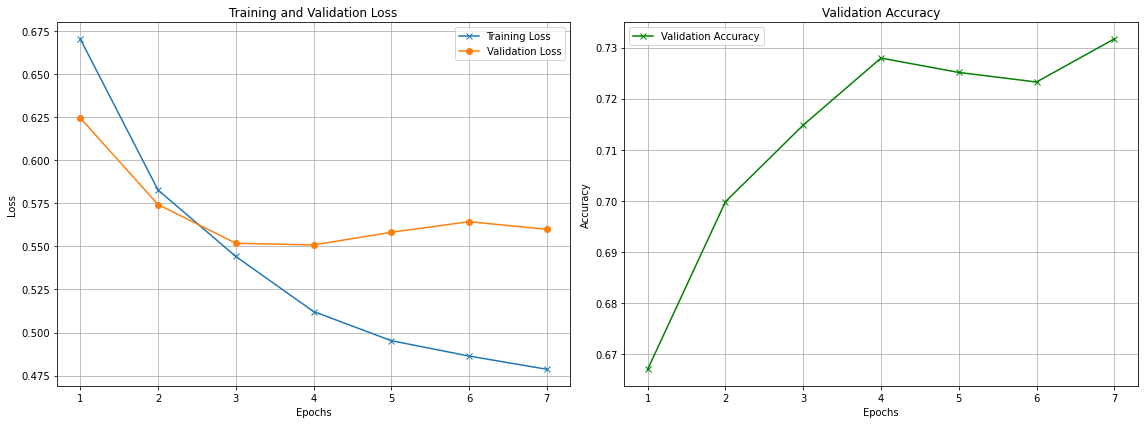

In [22]:
# visualization 1: train / val curve

epochs = list(range(1, len(val_losses) + 1))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# 1. Training and Validation Loss
ax1.plot(epochs, train_losses, label='Training Loss', marker='x')
ax1.plot(epochs, val_losses, label='Validation Loss', marker='o')
ax1.set_title('Training and Validation Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.grid(True)
ax1.legend()

# 2. Validation Accuracy
ax2.plot(epochs, val_accs, label='Validation Accuracy', color='green', marker='x')
ax2.set_title('Validation Accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.grid(True)
ax2.legend()

plt.tight_layout()
plt.show()

In [23]:
# compute predictions and labels for confusion matrix computing
def compute_pedictions_and_labels(
        model : nn.Module, 
        test_loader : DataLoader, 
        device : torch.device
    ) -> tuple:
    
    model.to(device)
    
    model.eval()
    
    # Lists to store all predictions and actual labels
    all_predictions = []
    all_labels = []
    
    with torch.no_grad():
        for data in test_loader:
            input_ids = data["input_ids"].to(device)
            attention_mask = data["attention_mask"].to(device)
            labels = data["label"].view(-1, 1).float().to(device)
            
            logits = model(input_ids, attention_mask=attention_mask)
     
            predictions = (logits > 0).long()
            
            all_predictions.extend(predictions.view(-1).cpu().numpy())
            all_labels.extend(labels.view(-1).cpu().numpy())
    
    return all_predictions, all_labels

all_predictions, all_labels = compute_pedictions_and_labels(cls_model, test_loader, device)

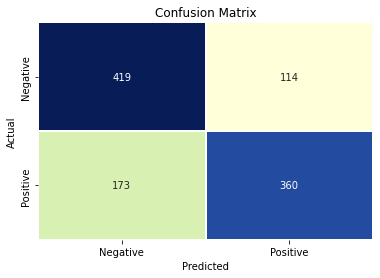

In [24]:
# visualization 2: confusion matrix

def plot_confusion(
        all_predictions : list, 
        all_labels : list
    ) -> None:      
            
    cm = confusion_matrix(all_labels, all_predictions) # from sklearn
            
    plt.figure(figsize=(6,4))
    sns.heatmap(cm, annot=True, fmt='d', linewidths=0.2, cmap="YlGnBu", cbar=False)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.xticks([0.5, 1.5], ['Negative', 'Positive'])
    plt.yticks([0.5, 1.5], ['Negative', 'Positive'], va='center')
    plt.show()
    
plot_confusion(all_predictions, all_labels)

In [25]:
def plot_f1_score(
        all_predictions : list, 
        all_labels : list
    ) -> None:
    f1 = f1_score(all_labels, all_predictions)
    print("F1 Score: ", f1)
    
plot_f1_score(all_predictions, all_labels)

F1 Score:  0.714995034756703


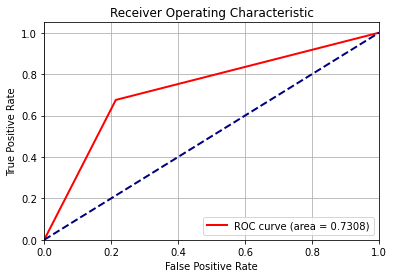

In [26]:
def plot_roc_curve(
        all_predictions : list, 
        all_labels : list
    ) -> None:
    fpr, tpr, _ = roc_curve(all_labels, all_predictions)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='r', lw=2, label=f"ROC curve (area = {roc_auc:0.4f})")
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver Operating Characteristic")
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()
    
plot_roc_curve(all_predictions, all_labels)

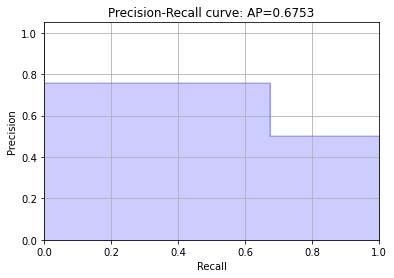

In [27]:
def plot_precision_recall_curve(
        all_predictions : list, 
        all_labels : list
    ) -> None:
    precision, recall, _ = precision_recall_curve(all_labels, all_predictions)
    average_precision = average_precision_score(all_labels, all_predictions)

    plt.figure()
    plt.step(recall, precision, color='b', alpha=0.2, where='post')
    plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title(f"Precision-Recall curve: AP={average_precision:.4f}")
    plt.grid(True)
    plt.show()
    
plot_precision_recall_curve(all_predictions, all_labels)